In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import numpy as np
import os, glob
import time
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Dataset

In [ ]:
texts = []
for path in glob.glob("drive/MyDrive/dataset/HW5/shahname/*.txt"):
  text = open(path, 'rb').read().decode(encoding='utf-8')
  texts.append(text)
texts = np.array(texts)
texts, texts_test = train_test_split(texts, train_size=0.9, random_state=22)
print(texts.shape)
print(texts_test.shape)

(561,)
(63,)


In [ ]:
texts = " ".join(texts)
seq_length = 250
texts = [texts[0+i:seq_length+i] for i in range(0, len(texts), seq_length)]
del texts[-1]
texts = np.array(texts)

Find Number of Unique Characters

In [ ]:
vocab = open("drive/MyDrive/dataset/HW5/allShahnameWords.txt", 'rb').read().decode(encoding='utf-8')
unique = [" ","\t"]
for char in vocab[::]:
    if char not in unique:
        unique.append(char)

print(sorted(unique))
print(len(unique))


['\t', '\n', ' ', '(', ')', '«', '»', '،', '؟', 'ء', 'آ', 'أ', 'ؤ', 'ئ', 'ا', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ل', 'م', 'ن', 'ه', 'و', 'ٔ', 'پ', 'چ', 'ژ', 'ک', 'گ', 'ی', '\u200c']
48


Vectorize the text

In [ ]:
ids_from_chars = preprocessing.StringLookup(vocabulary=unique, mask_token=None)

chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

Create training examples and targets

In [ ]:
all_ids = []
for text in texts:
  text = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
  all_ids.append(text)
all_ids = np.array(all_ids)

test_ids = []
for text in texts_test:
  text = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
  test_ids.append(text)

In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

X = []
Y = []
for row in all_ids:
  x,y = split_input_target(row)
  X.append(x)
  Y.append(y)
X = np.array(X)
Y = np.array(Y)

X, X_valid, Y, Y_valid = train_test_split(X, Y, train_size=0.75, random_state=22)

dataset = tf.data.Dataset.from_tensor_slices((X,Y))

val_dataset = tf.data.Dataset.from_tensor_slices((X_valid,Y_valid))
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

val_dataset = (
    val_dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))


Build The Model

In [ ]:
vocab_size = len(unique)

embedding_dim = 64

rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.lstm = tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=[None,None], return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states[0] is None:
      mStates, cStates = self.lstm.get_initial_state(x)
    else:
      mStates, cStates = states[0], states[1]
    x, mStates, cStates = self.lstm(x, initial_state=[mStates, cStates], training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, mStates, cStates
    else:
      return x


model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
sampled_indices

print("Input:\n", text_from_ids(input_example_batch[0]).numpy().decode('UTF-8'))
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy().decode('UTF-8'))

(64, 249, 49) # (batch_size, sequence_length, vocab_size)
Input:
 وی
ازان پس بپرسید و بنواختش	یکی نامور جایگه ساختش
 چو آمد به نزدیکی هیرمند	فرستاده‌ای برگزید ارجمند
فرستاد نزدیک دستان سام	بدادش ز هر گونه چندی پیام
چنین گفت کز کین اسفندیار	مرا تلخ شد در جهان روزگار
هم از کین نوش‌آذر و مهر نوش	دو شاه گرامی دو فرخ س

Next Char Predictions:
 (عقأغ‌دشچعصتح
بخضچغجیٔد‌ل(عچٔ)دٔهآاطئیظقجتصپطظضرخثهثقرض)ب(عج
ئوغؤکپز(»ش»طوزضر»ر[UNK]ؤعنشکیغ«(
طپآن[UNK](؟ی‌جقژ(( قنپکد	ئوبصزئذشصیرٔ	،قثیط(ژغز«ف[UNK][UNK]قظ،شخر[UNK]»(قجنجویچد[UNK]جگ[UNK]یچ؟«ظظ«ش‌خخو‌مهیگحؤحنهنمچدوث»[UNK]ئخی«خمتظبضوس	رغهرب»قچچ
عسسگدکخصل‌بمغصف؟[UNK]‌به و	آکٔصضظسوی؟هرنه‌


In [ ]:
tf.keras.backend.clear_session()

Train the model

In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, validation_data=val_dataset)

Epoch 1/50
105/105 [==============================] - 18s 160ms/step - loss: 2.9613 - accuracy: 0.1845 - val_loss: 2.6855 - val_accuracy: 0.2561
Epoch 2/50
105/105 [==============================] - 17s 161ms/step - loss: 2.5210 - accuracy: 0.2860 - val_loss: 2.4178 - val_accuracy: 0.3024
Epoch 3/50
105/105 [==============================] - 17s 164ms/step - loss: 2.3570 - accuracy: 0.3134 - val_loss: 2.2757 - val_accuracy: 0.3307
Epoch 4/50
105/105 [==============================] - 18s 168ms/step - loss: 2.1923 - accuracy: 0.3532 - val_loss: 2.0686 - val_accuracy: 0.3854
Epoch 5/50
105/105 [==============================] - 18s 170ms/step - loss: 1.9655 - accuracy: 0.4143 - val_loss: 1.8733 - val_accuracy: 0.4416
Epoch 6/50
105/105 [==============================] - 18s 170ms/step - loss: 1.8024 - accuracy: 0.4639 - val_loss: 1.7355 - val_accuracy: 0.4854
Epoch 7/50
105/105 [==============================] - 18s 172ms/step - loss: 1.6732 - accuracy: 0.5048 - val_loss: 1.6180 - val_ac

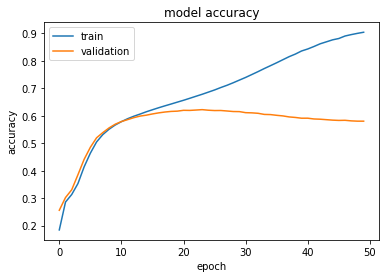

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


Generate text

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=0.3):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=[None,None]):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    mStates, cStates = None, None
    predicted_logits, mStates, cStates = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, mStates,cStates

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)
start = time.time()
mStates,cStates = None,None
next_char = tf.constant(['م'])
result = [next_char]

for n in range(250-len(next_char)):
  next_char, mStates,cStates = one_step_model.generate_one_step(next_char, states=[mStates,cStates])
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

می بر سر افسر نهی
چه گویید کز رنج و زندان بود	وزان جایگه بر تواناترست
کسی کاو به فرمان ما بشکنید	ز پیوند خورشید روی هوایش بود
به پیش اندر آید گرفته رهی	ازو چون بر ماه باشد ستم
چو شد روز روشن روان و خرد	همی مهتر از گردش روز زرد
چنین گفت کاین روز فرخ ن 

________________________________________________________________________________

Run time: 1.2867467403411865


Accuracy of test set

Accuracy for test set:  0.5756358768406962


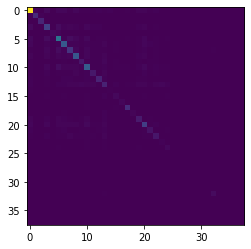

In [ ]:
test_slices = np.array([text[:seq_length] for text in test_ids])
X_test = []
Y_test = []
for row in test_slices:
  x,y = split_input_target(row)
  X_test.append(x)
  Y_test.append(y)
X_test = np.array(X_test)
Y_test = np.array(Y_test)
predictions = np.array(model.predict(X_test))
sampled_indices = [tf.random.categorical(predictions[i], num_samples=1) for i in range(len(predictions))]
sampled_indices = [tf.squeeze(sampled_indices[i], axis=-1).numpy() for i in range(len(predictions))]
sampled_indices = np.array(sampled_indices)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
conf = confusion_matrix(Y_test.ravel(), sampled_indices.ravel())
print("Accuracy for test set: ", accuracy_score(Y_test.ravel(), sampled_indices.ravel()))
plt.imshow(conf)
plt.show()


Prepare dataset for bleu



In [ ]:
X_test_split = []
Y_test_split = []
for i in range(len(test_ids)):
  text = text_from_ids(X_test[i]).numpy().decode('utf-8').replace("\t", " \t ").replace("\n", " \n ").split(" ")
  X_test_split.append(text)
  text = text_from_ids(Y_test[i]).numpy().decode('utf-8').replace("\t", " \t ").replace("\n", " \n ").split(" ")
  Y_test_split.append(text)


In [ ]:
predicts = []

for i,poem in enumerate(X_test_split):
  next_char = tf.constant([poem[0]])
  result = [next_char]
  for n in range(seq_length-len(poem[0])):
    next_char, mStates,cStates = one_step_model.generate_one_step(next_char, states=[mStates,cStates])
    result.append(next_char)
  
  result = tf.strings.join(result)
  result = result[0].numpy().decode('utf-8')
  predicts.append(result)


In [ ]:
print(predicts[2], '\n\n' + '_'*80)
print(predicts[5].replace("\t","**"), '\n\n' + '_'*80)
print(predicts[43].replace("\t","**"), '\n\n' + '_'*80)

چوان	به در بر نهادند کار از گناه
گزین کرد زان انجمن رستخیز	بدان تا نباشد به دیدار خویش
همان گیو و گودرز و چندی درنگ	به پیش سواران نهادند روی
پس از دامن کوه بنهاد روی	چو سندان ودهدام پیروز شور
بپرسید بهرام زو هر چه بود	که نزدیک او مهتران سترگ
برزم اند 

________________________________________________________________________________
چو زیر**پی او شود با نیایش یکی تخت پای
ندارند جان شاه را ساختند**ز بیداری اختر بیاراستند
که بازی کنون کار مردان بود**ز بد روز بی‌ایشه و موبدند
وگر تاج بیدار گردد درخت**زمین را به خون پدر بی‌پرست
بیاورد بهرام و خود ریختن**نشستند با خاک بفتی من
ازان پس بگفت 

________________________________________________________________________________
چوی و هم کرده‌ام
به پیش پدر شد پرستار شاه**پدر را بکردار توران سپاه
چو بر تخت بنشست فرخ قباد**کلاه بزرگی به سر برنهاد
همه دست بردست او را ببرد**به باد افره ایزدی چند مرد
ببردند پس تاجها برنشست**برو گشت چون ماه پیچان کنند
بدو گفت کای مرد بدبخت خوار**که فرد 

_____________________________________________________________________

In [ ]:
predict_split = []
for i in range(len(predicts)):
  text = predicts[i].replace("\t", " \t ").replace("\n", " \n ").split(" ")
  predict_split.append(text)


In [ ]:
import nltk
bleu = 0
for i in range(len(predict_split)):
  hypothesis = predict_split[i][1:]
  reference = Y_test_split[i][1:]
  BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = [1])
  bleu += BLEUscore
print(bleu/len(predict_split))

0.2701648072568281
